In [ ]:
!pip install Augmentor

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.6/793.6 kB 11.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

In [ ]:
!pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d ammarahmed310/labeled-mri-brain-tumor-dataset

Dataset URL: https://www.kaggle.com/datasets/ammarahmed310/labeled-mri-brain-tumor-dataset
License(s): CC0-1.0
100% 52.0M/52.1M [00:01<00:00, 39.0MB/s]
100% 52.1M/52.1M [00:01<00:00, 28.9MB/s]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import cv2
import math
import os
import zipfile
import random
import shutil
import Augmentor
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
from PIL import Image
from IPython.display import display

# eda


In [ ]:
with zipfile.ZipFile('labeled-mri-brain-tumor-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('mri-brain-tumor-')

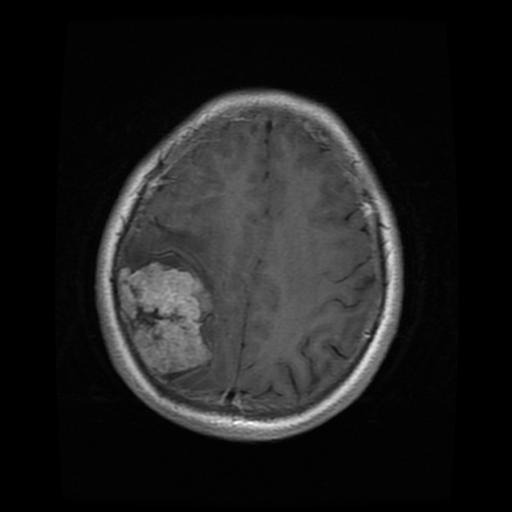

In [ ]:
sample_image = Image.open('/content/mri-brain-tumor-/Brain Tumor labeled dataset/meningioma/Tr-me_0010.jpg')
sample_image

In [ ]:
sample_image.size

(512, 512)

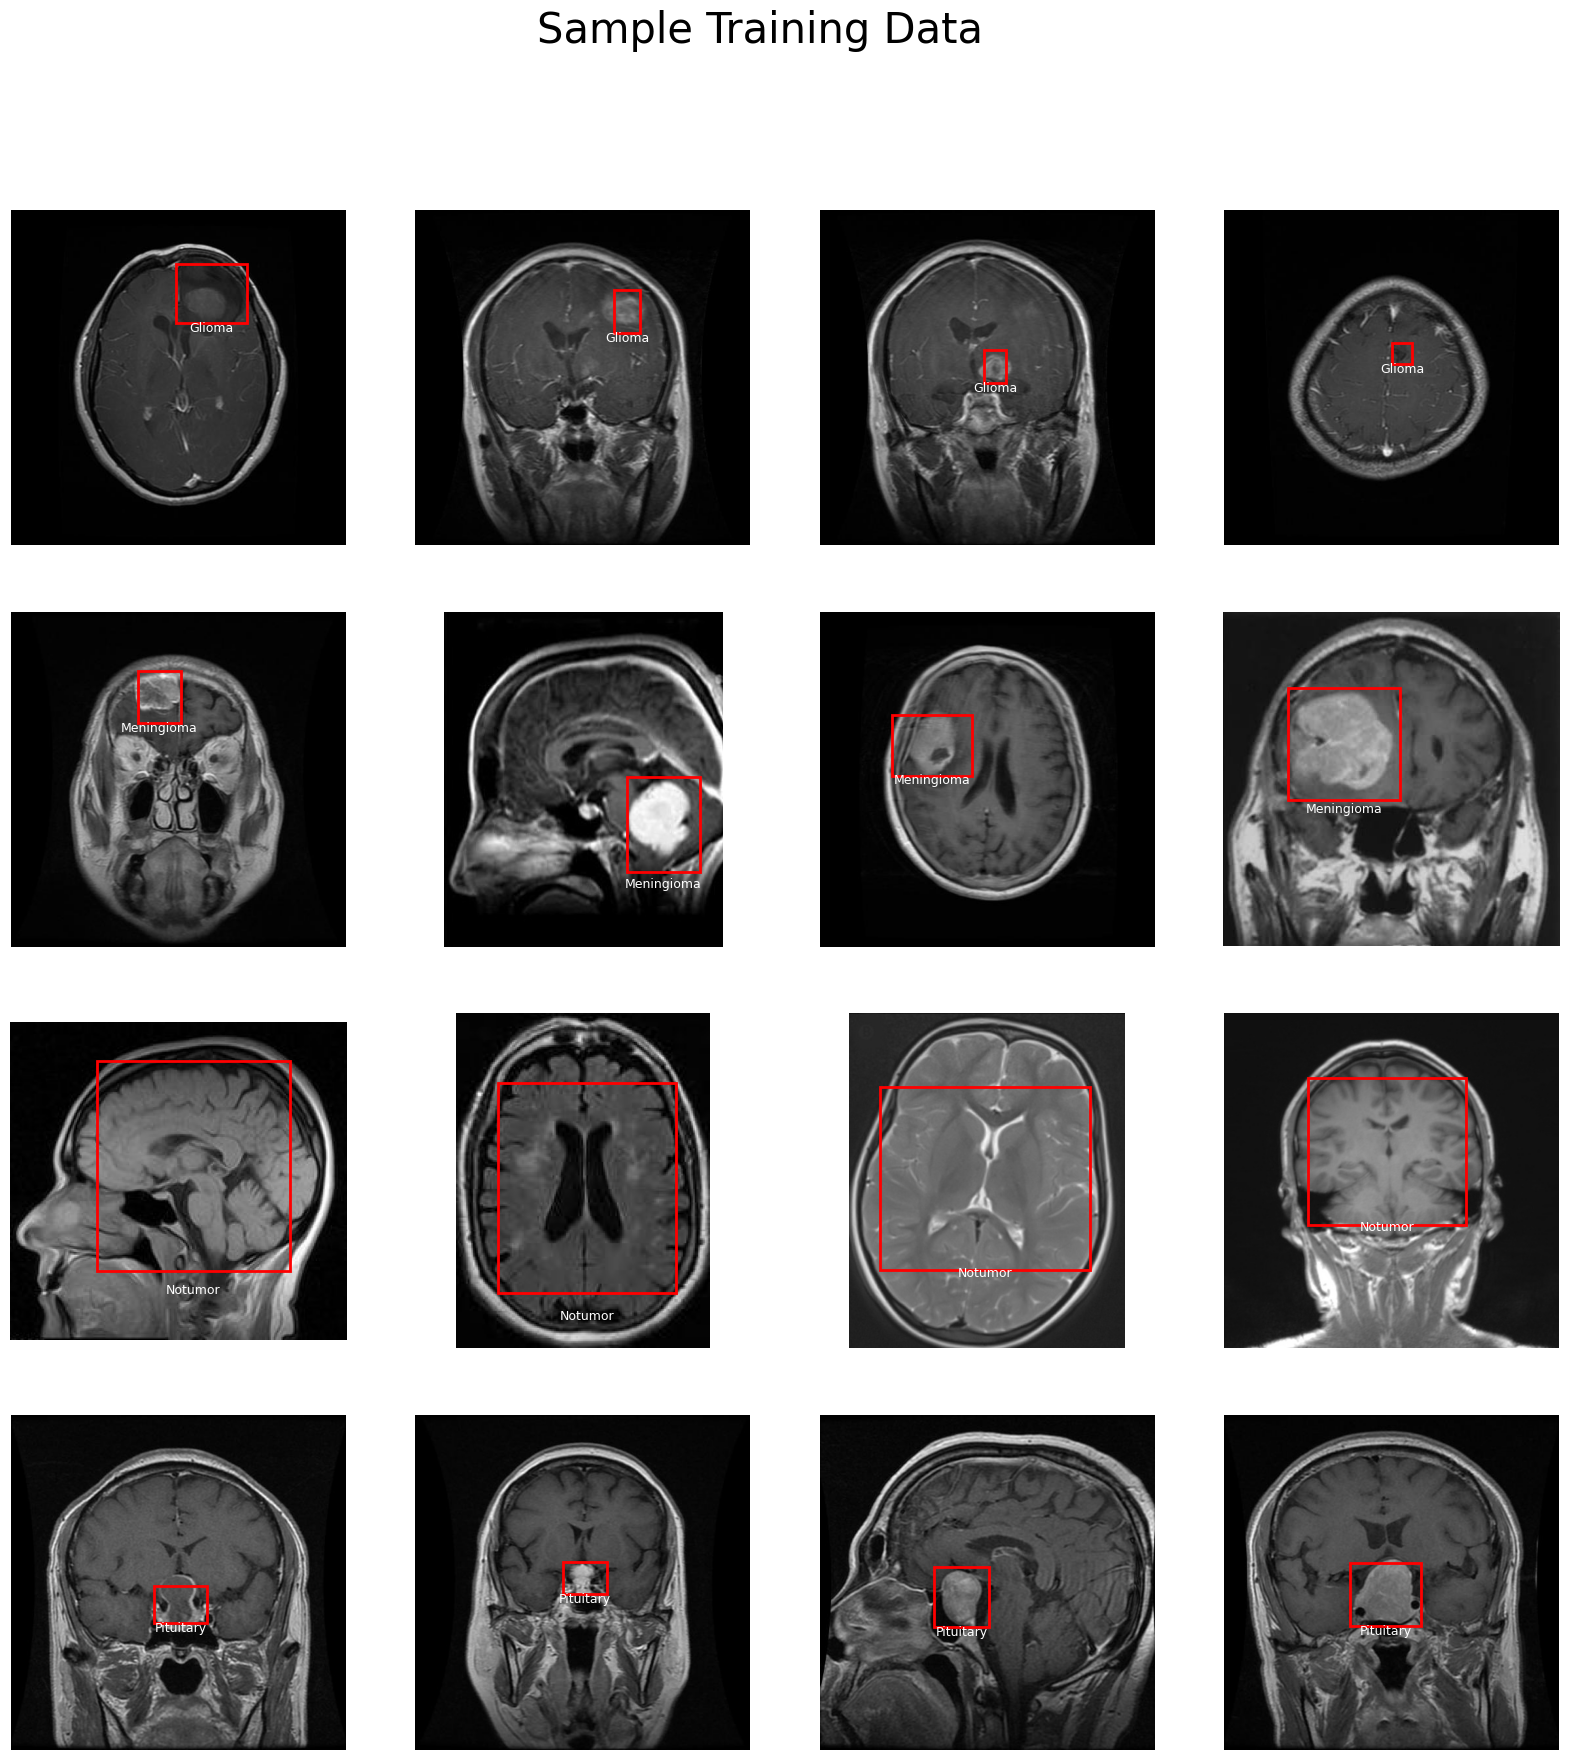

In [ ]:
# Plotting the training data with bounding boxes
dataset_directory = '/content/mri-brain-tumor-/Brain Tumor labeled dataset'
class_labels = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

fig, axes = plt.subplots(4, 4, figsize=(20, 20))

for class_name, ax_row in zip(class_labels.keys(), axes):
    class_directory = os.path.join(dataset_directory, class_name)
    image_files = [f for f in os.listdir(class_directory) if f.endswith('.jpg')]

    if len(image_files) < 4:
      raise ValueError(f"Not enough images in {class_name} directory to sample.")

    selected_images = random.sample(image_files, 4)

    for ax, image_file in zip(ax_row, selected_images):
        annotation_file = os.path.join(class_directory, image_file.replace('.jpg', '.txt'))
        with open(annotation_file, 'r') as file:
            line = file.readline().strip().split()
            class_number, centre_x, centre_y, height, width = map(float, line)

        img = plt.imread(os.path.join(class_directory, image_file))

        if len(img.shape) == 2:
            img = np.stack((img,) * 3, axis=-1)

        img_height, img_width, _ = img.shape
        x_min = (centre_x - width / 2) * img_width
        y_min = (centre_y - height / 2) * img_height
        x_max = (centre_x + width / 2) * img_width
        y_max = (centre_y + height / 2) * img_height
        tumor_bbox = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none', label=f'{class_name.capitalize()}')
        ax.imshow(img)
        ax.add_patch(tumor_bbox)

        label_text = f'{class_name.capitalize()}'
        ax.text((x_min + x_max) / 2, y_max + 18, label_text, color='w', ha='center', va='bottom', fontsize=9)

for ax_row in axes:
    for ax in ax_row:
        ax.axis('off')

plt.suptitle("Sample Training Data", fontsize=30)
plt.show()

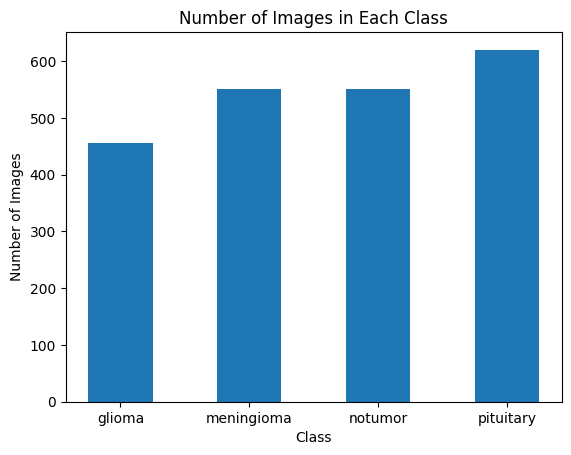

In [ ]:
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
class_counts = [456, 551, 550, 620]

plt.bar(class_names, class_counts, width=0.5)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.show()

# train-test split

In [ ]:
def custom_train_test_split(dataset_directory, test_ratio=0.2, random_seed=None, min_samples_per_class=2):
    """
    Custom function to perform a stratified train-test split on an image dataset.
    This function organizes the dataset into 'train' and 'test' directories while maintaining the class-wise distribution.
    It creates the 'train' and 'test' directories within the given dataset directory and moves images accordingly.
    """
    random_seed = random_seed or 42

    class_directories = [d for d in os.listdir(dataset_directory) if os.path.isdir(os.path.join(dataset_directory, d))]

    train_directory = os.path.join(dataset_directory, 'train')
    test_directory = os.path.join(dataset_directory, 'test')
    os.makedirs(train_directory, exist_ok=True)
    os.makedirs(test_directory, exist_ok=True)

    for class_dir in class_directories:
        class_path = os.path.join(dataset_directory, class_dir)

        image_files = [f for f in os.listdir(class_path) if f.endswith('.jpg')]

        if len(image_files) < min_samples_per_class:
            continue

        train_images, test_images = train_test_split(image_files, test_size=test_ratio, random_state=random_seed)

        for train_image in train_images:
            src_image_path = os.path.join(class_path, train_image)
            src_annotation_path = os.path.join(class_path, train_image.replace('.jpg', '.txt'))

            dest_image_path = os.path.join(train_directory, class_dir, train_image)
            dest_annotation_path = os.path.join(train_directory, class_dir, train_image.replace('.jpg', '.txt'))

            os.makedirs(os.path.dirname(dest_image_path), exist_ok=True)

            if os.path.exists(src_annotation_path):
                shutil.move(src_image_path, dest_image_path)
                shutil.move(src_annotation_path, dest_annotation_path)

        for test_image in test_images:
            src_image_path = os.path.join(class_path, test_image)
            src_annotation_path = os.path.join(class_path, test_image.replace('.jpg', '.txt'))

            dest_image_path = os.path.join(test_directory, class_dir, test_image)
            dest_annotation_path = os.path.join(test_directory, class_dir, test_image.replace('.jpg', '.txt'))

            os.makedirs(os.path.dirname(dest_image_path), exist_ok=True)

            if os.path.exists(src_annotation_path):
                shutil.move(src_image_path, dest_image_path)
                shutil.move(src_annotation_path, dest_annotation_path)


In [ ]:
custom_train_test_split(dataset_directory, test_ratio=0.2, random_seed=42, min_samples_per_class=2)

In [ ]:
def count_images_per_class(directory):
    class_counts = {}
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):
            class_counts[class_dir] = len([f for f in os.listdir(class_path) if f.endswith('.jpg')])
    return class_counts

In [ ]:
def plot_image_counts(train_directory, test_directory):
    """
    Plot the number of images in each class for both the training and testing sets.
    This function counts the number of images in each class for both the training and testing sets
    and plots a bar chart to visualize the distribution.
    """
    train_counts = count_images_per_class(train_directory)
    test_counts = count_images_per_class(test_directory)

    class_names = list(train_counts.keys())
    train_counts_values = list(train_counts.values())
    test_counts_values = [test_counts[class_name] for class_name in class_names]

    bar_width = 0.35
    index = range(len(class_names))

    fig, ax = plt.subplots()
    bar1 = ax.bar(index, train_counts_values, bar_width, label='Train')
    bar2 = ax.bar([i + bar_width for i in index], test_counts_values, bar_width, label='Test')

    ax.set_xlabel('Class')
    ax.set_ylabel('Number of Images')
    ax.set_title('Number of Images in Each Class for Train and Test Sets')
    ax.set_xticks([i + bar_width/2 for i in index])
    ax.set_xticklabels(class_names)
    ax.legend()

    plt.show()

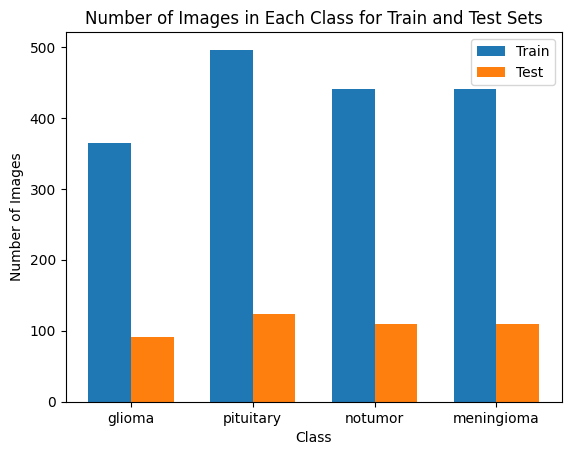

In [ ]:
train_directory = os.path.join(dataset_directory, 'train')
test_directory = os.path.join(dataset_directory, 'test')

plot_image_counts(train_directory, test_directory)

In [ ]:
import tensorflow as tf
dataset_directory = '/content/mri-brain-tumor-/Brain Tumor labeled dataset'
class_label = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
MAX_BBOXES = 20
def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [256, 256])  # Resize to a standard size
    img = tf.cast(img, tf.float32) / 255.0  # Normalize to [0, 1]
    return img

# Function to preprocess annotations
def preprocess_annotation(annotation_path, max_bboxes=MAX_BBOXES):
    annotation_content = tf.io.read_file(annotation_path)
    lines = tf.strings.split(annotation_content, '\n')

     # Filter out empty lines
    lines = tf.boolean_mask(lines, tf.strings.length(lines) > 0)

    annotations = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    classes = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)

    def parse_line(line):
        parts = tf.strings.split(line)
        class_label = tf.strings.to_number(parts[0], out_type=tf.int32)
        x_center = tf.strings.to_number(parts[1], out_type=tf.float32)
        y_center = tf.strings.to_number(parts[2], out_type=tf.float32)
        width = tf.strings.to_number(parts[3], out_type=tf.float32)
        height = tf.strings.to_number(parts[4], out_type=tf.float32)

        # Convert to YOLO format (normalized coordinates)
        x_min = x_center - width / 2.0
        y_min = y_center - height / 2.0
        x_max = x_center + width / 2.0
        y_max = y_center + height / 2.0

        return tf.stack([x_min, y_min, x_max, y_max]), class_label

    for i in tf.range(tf.size(lines)):
        line = lines[i]
        annotation, class_label = parse_line(line)
        annotations = annotations.write(i, annotation)
        classes = classes.write(i, class_label)

    # Stack and pad annotations and classes
    annotations = annotations.stack()
    classes = classes.stack()
    annotations = tf.pad(annotations, [[0, max_bboxes - tf.shape(annotations)[0]], [0, 0]])
    classes = tf.pad(classes, [[0, max_bboxes - tf.shape(classes)[0]]])

    return {"boxes": annotations, "classes": classes}

def load_dataset(directory,  max_bboxes=MAX_BBOXES):
    image_path = []
    annotation_path = []

    # Iterate through directories and collect image and annotation paths
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.jpg'):
                image_path.append(os.path.join(root, file))
                annotation_path.append(os.path.join(root, file.replace('.jpg', '.txt')))

     # Create TensorFlow dataset from image and annotation paths
    dataset = tf.data.Dataset.from_tensor_slices((image_path, annotation_path))
    dataset = dataset.map(lambda image_path, annotation_path: (preprocess_image(image_path), preprocess_annotation(annotation_path, max_bboxes)))

    return dataset
# Load training and validation datasets
train_directory = os.path.join(dataset_directory, 'train')
test_directory = os.path.join(dataset_directory, 'test')

train_dataset = load_dataset(train_directory)
test_dataset = load_dataset(test_directory)



# YOLOv8

In [ ]:
!pip install --upgrade git+https://github.com/keras-team/keras-cv -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 10.4 MB/s eta 0:00:00


In [ ]:
# creating mirrored strategy

stg = tf.distribute.MirroredStrategy()

In [ ]:
class_mapping = dict(zip(range(len(class_labels)), class_labels))

class_mapping

{0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}

In [ ]:
class LossCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(LossCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            loss = logs.get('loss')
            if loss is not None and loss < self.threshold:
                print(f"\nLoss has reached {loss}, below threshold {self.threshold}. Stopping training!")
                self.model.stop_training = True
loss_threshold = 0.001  # Define your loss threshold

# Usage example
callback = [LossCallback(threshold=loss_threshold)]

In [ ]:
# Placeholder function to calculate average precision
def calculate_average_precision(gt_boxes, gt_classes, pred_boxes, pred_scores, pred_classes, iou_threshold, score_threshold):
    # Implement logic to calculate AP (Mean Average Precision)
    # This function will depend on how you want to evaluate the precision of your model
    # For this example, a placeholder is used
    return 0.0


In [ ]:
import keras_cv
from tensorflow import keras
from tensorflow.keras.optimizers import AdamW

GLOBAL_CLIPNORM = 10.0

# Assuming `class_mapping` and `stg` are defined somewhere in your code

# Create YOLOV8 model and compile it
with stg.scope():
    backbone = keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_xs_backbone_coco")

    YOLOV8_model = keras_cv.models.YOLOV8Detector(
        num_classes=len(class_mapping),
        bounding_box_format="xyxy",
        backbone=backbone,
        fpn_depth=1
    )

    optimizer = AdamW(
        learning_rate=0.001,
        weight_decay=0.004,
        global_clipnorm=GLOBAL_CLIPNORM
    )

    YOLOV8_model.compile(
        optimizer=optimizer,
        classification_loss='binary_crossentropy',
        box_loss='ciou'
    )

    # Define a decorated train_step function to handle data unpacking
    def decorated_train_step(self, data):
        # Unpack the data if it's a tuple
        if isinstance(data, tuple):
            x, y = data
            # Ensure x has a batch dimension if missing, and handle single-image case
            if x.shape.rank == 3:  # If x is a single image without batch dimension
                x = tf.expand_dims(x, axis=0)  # Add batch dimension
            data = (x, y)  # Repack the data
        return super(keras_cv.models.YOLOV8Detector, self).train_step(data)

    # Monkey-patch the YOLOV8Detector class with the decorated train_step
    YOLOV8_model.train_step = decorated_train_step.__get__(YOLOV8_model, keras_cv.models.YOLOV8Detector)

# Assuming `train_dataset` and `test_dataset` are prepared correctly

In [ ]:
batch_size = 8  # or any suitable batch size
train_dataset = load_dataset(train_directory).batch(batch_size).shuffle(buffer_size=1000)
test_dataset = load_dataset(test_directory).batch(batch_size)
# History object to store the training history
history = YOLOV8_model.fit(train_dataset, validation_data=test_dataset, callbacks =callback, epochs=100, verbose=1)


Epoch 1/100
218/218 [==============================] - 63s 93ms/step - loss: 829.1165 - box_loss: 0.0000e+00 - class_loss: 829.1165 - val_loss: 9.1721 - val_box_loss: 0.0000e+00 - val_class_loss: 9.1721
Epoch 2/100
218/218 [==============================] - 20s 82ms/step - loss: 1.2185 - box_loss: 0.0000e+00 - class_loss: 1.2185 - val_loss: 0.3019 - val_box_loss: 0.0000e+00 - val_class_loss: 0.3019
Epoch 3/100
218/218 [==============================] - 20s 82ms/step - loss: 0.1825 - box_loss: 0.0000e+00 - class_loss: 0.1825 - val_loss: 0.1228 - val_box_loss: 0.0000e+00 - val_class_loss: 0.1228
Epoch 4/100
218/218 [==============================] - 20s 79ms/step - loss: 0.0866 - box_loss: 0.0000e+00 - class_loss: 0.0866 - val_loss: 0.0669 - val_box_loss: 0.0000e+00 - val_class_loss: 0.0669
Epoch 5/100
218/218 [==============================] - 20s 82ms/step - loss: 0.0511 - box_loss: 0.0000e+00 - class_loss: 0.0511 - val_loss: 0.0417 - val_box_loss: 0.0000e+00 - val_class_loss: 0.0417
E

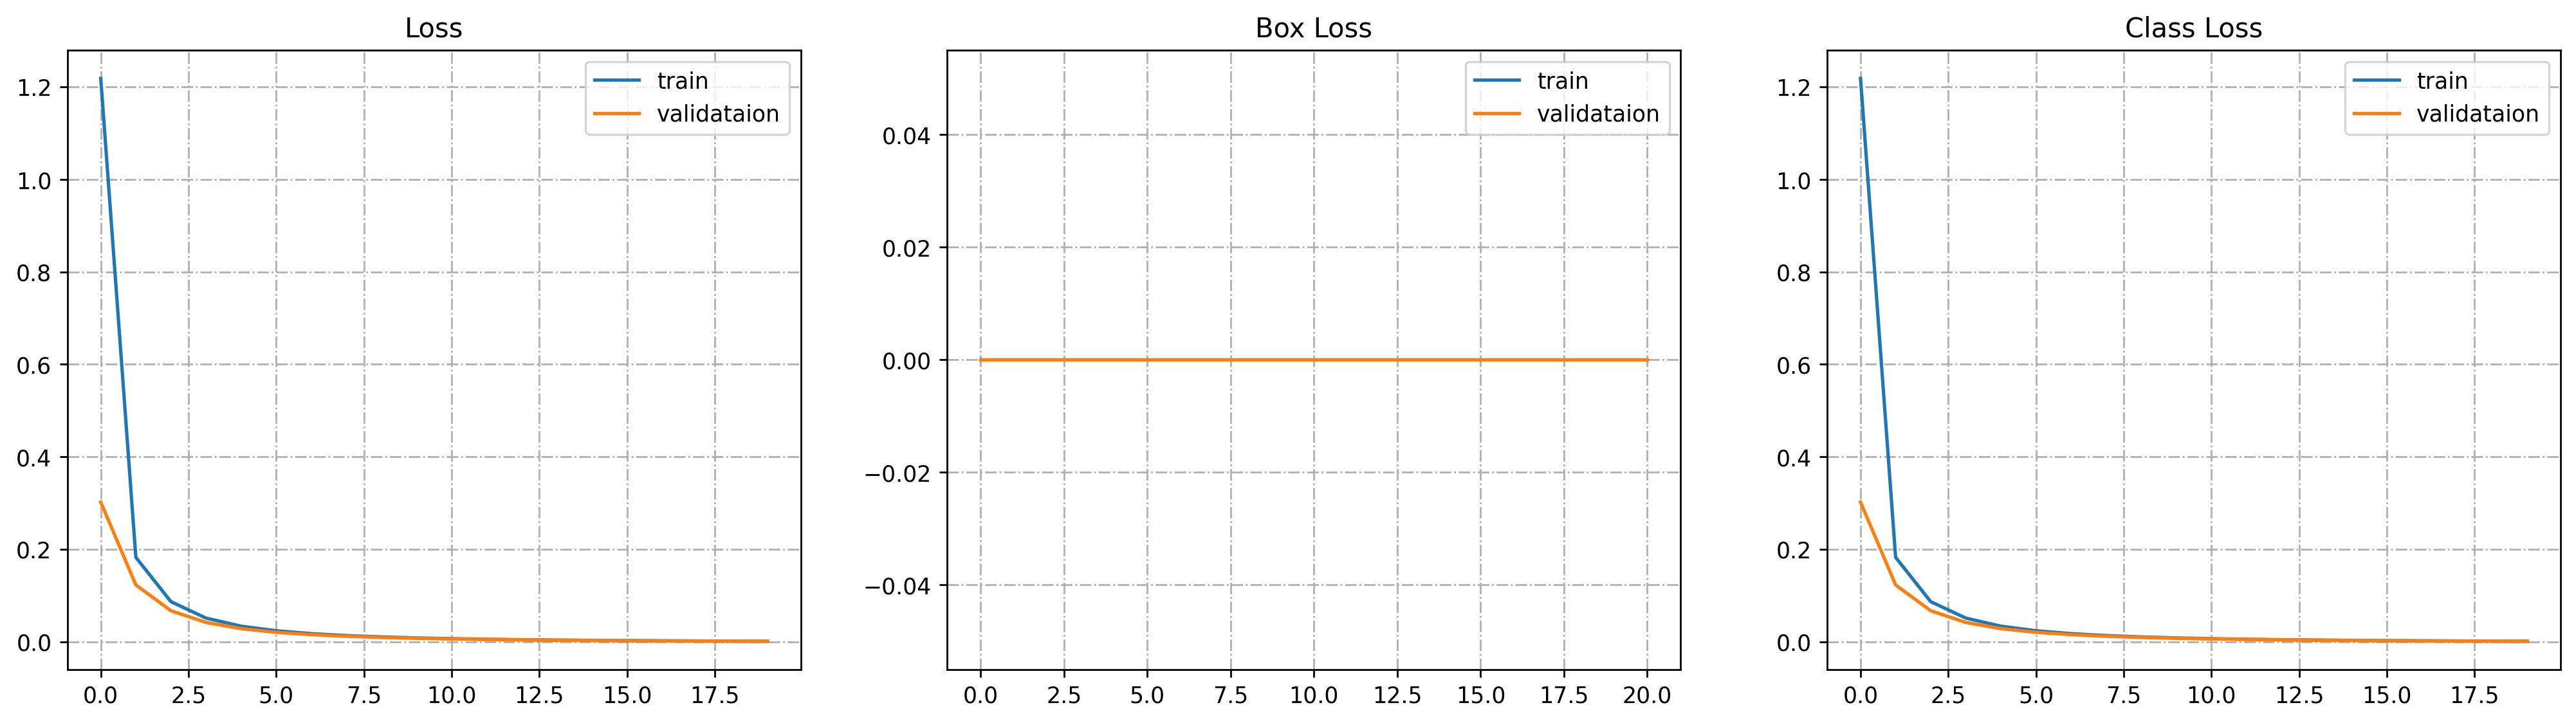

In [ ]:
fig, axs = plt.subplots(1,3, figsize = (20,5), dpi = 250)

axs[0].grid(linestyle="dashdot")
axs[0].set_title("Loss")
axs[0].plot(history.history['loss'][1:])
axs[0].plot(history.history['val_loss'][1:])
axs[0].legend(["train", "validataion"])

axs[1].grid(linestyle="dashdot")
axs[1].set_title("Box Loss")
axs[1].plot(history.history['box_loss'])
axs[1].plot(history.history['val_box_loss'])
axs[1].legend(["train",  "validataion"])

axs[2].grid(linestyle="dashdot")
axs[2].set_title("Class Loss")
axs[2].plot(history.history['class_loss'][1:])
axs[2].plot(history.history['val_class_loss'][1:])
axs[2].legend(["train",  "validataion"])


plt.show()